In [12]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
train = pd.read_csv('train.csv',encoding = "gbk")
print(train.head(3))
test = pd.read_csv('test.csv',encoding = "gbk")
print(test.head(3))
df_all = train.append(test,ignore_index=True)
df0 = df_all[df_all["Stance"] == "unrelate"]
df0["Stance"] = 0
df1 = df_all[df_all["Stance"] == "agree"]
df1["Stance"] = 1
df2 = df_all[df_all["Stance"] == "disagree"]
df2["Stance"] = 0
df3 = df_all[df_all["Stance"] == "discuss"]
df3["Stance"] = 1
df_all = df0.append(df1,ignore_index=True)
df_all = df_all.append(df2,ignore_index=True)
df_all = df_all.append(df3,ignore_index=True)

                                            Headline  Body ID     Stance  \
0     Soldier shot near Canadian parliament building        0  unrelated   
1  Tourist dubbed ‘Spider Man’ after spider burro...        0  unrelated   
2  Apple Watch to Be Shower-Proof, Have 100,000 A...        0  unrelated   

                                                Body  
0  A small meteorite crashed into a wooded area i...  
1  A small meteorite crashed into a wooded area i...  
2  A small meteorite crashed into a wooded area i...  
                                            Headline  Body ID     Stance  \
0  18-Karat Gold Apple Watch Edition To Be Locked...        1  unrelated   
1  Apple Stores to Keep Gold “Edition” Apple Watc...        1  unrelated   
2                  Apple Watches to be kept in safes        1  unrelated   

                                                Body  
0  Al-Sisi has denied Israeli reports stating tha...  
1  Al-Sisi has denied Israeli reports stating tha...  
2  Al

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Modeling

In [9]:
# Preparing the target and predictors for modeling

X_body_text = df_all.Body.values
X_headline_text = df_all.Headline.values
y = df_all.Stance.values

tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)
X_body_tfidf = tfidf.fit_transform(X_body_text)
X_headline_tfidf = tfidf.fit_transform (X_headline_text)
X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y, test_size = 0.2, random_state=1234)
X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf,y, test_size = 0.2, random_state=1234)
print("done")

done


Learning Curve

In [28]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);
        plt.show()

Logistic Regression
Using the headline of the article

In [18]:
lr_headline = LogisticRegression(penalty='l1')
print(X_headline_tfidf_train.shape)
print(X_headline_tfidf_test.shape)

(16392, 154)
(4099, 154)


In [19]:
# train model
lr_headline.fit((X_headline_tfidf_train), y_headline_train)

# get predictions for article section
y_headline_pred = lr_headline.predict(X_headline_tfidf_test)

In [20]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_headline_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 48.03%
Accuracy score 92.41%


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
cros_val_list = cross_val_score(lr_headline, X_headline_tfidf,y,cv=7)
print(cros_val_list)
print(cros_val_list.mean())

[ 0.91290984  0.87329235  0.9238388   0.92486339  0.92517936  0.92515379
  0.91866029]
0.914842545254


Learning Curve for headline logistic regression

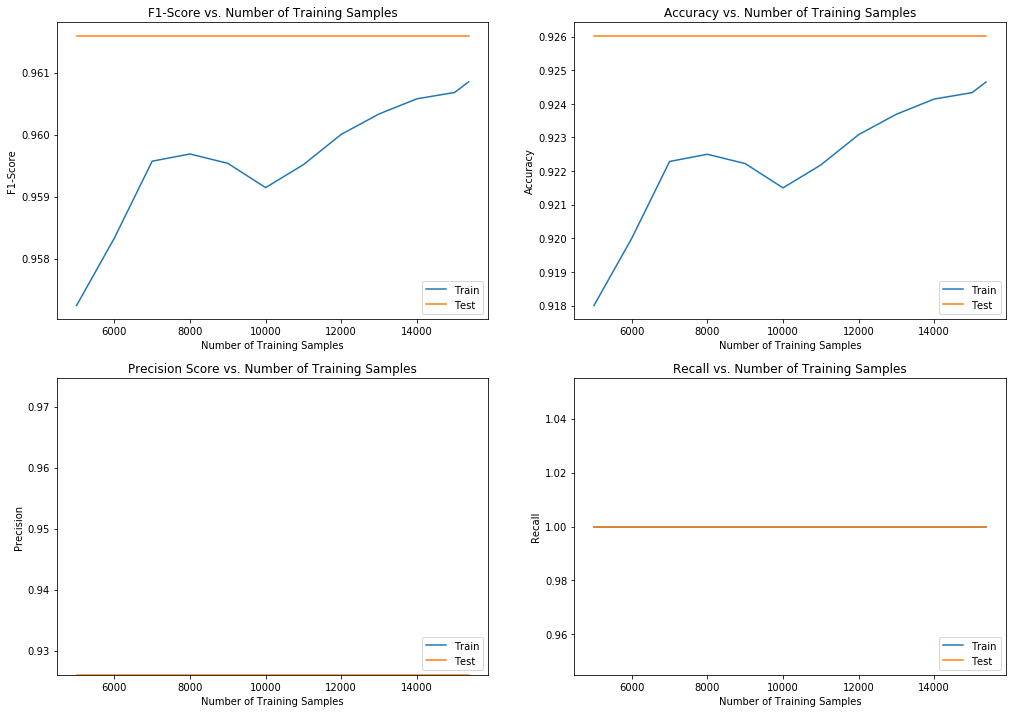

In [51]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000,average="binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

Logistic Regression
Using Body of the article

In [36]:
lr_body = LogisticRegression(penalty='l1')

# train model
lr_body.fit(X_body_tfidf_train, y_body_train)

# get predictions for article section
y_body_pred = lr_body.predict(X_body_tfidf_test)

In [37]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_body_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 59.16%
Accuracy score 92.36%


In [38]:
cros_val_list = cross_val_score(lr_body, X_body_tfidf,y,cv=7)
print(cros_val_list)
print(cros_val_list.mean())

[ 0.8886612   0.8261612   0.8989071   0.91598361  0.91014691  0.91524265
  0.91592618]
0.89586126486


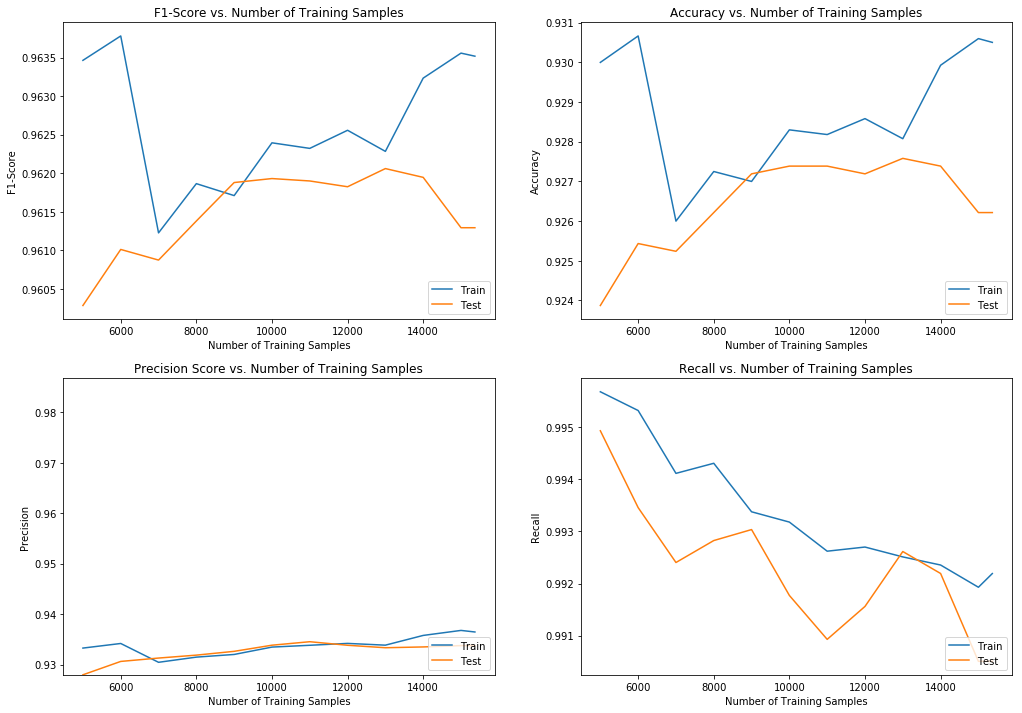

In [39]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

Random Forest

In [42]:
rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)
rcf_headline.fit(X_headline_tfidf_train, y_headline_train)
y_rc_headline_pred = rcf_headline.predict(X_headline_tfidf_test)

In [43]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_rc_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_rc_headline_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 53.69%
Accuracy score 92.39%


In [46]:
cros_val_list = cross_val_score(rcf_headline, X_headline_tfidf,y,cv=5)
print(cros_val_list)
print(cros_val_list.mean())

[ 0.88704562  0.87655526  0.92313324  0.92215715  0.92335856]
0.906449963771


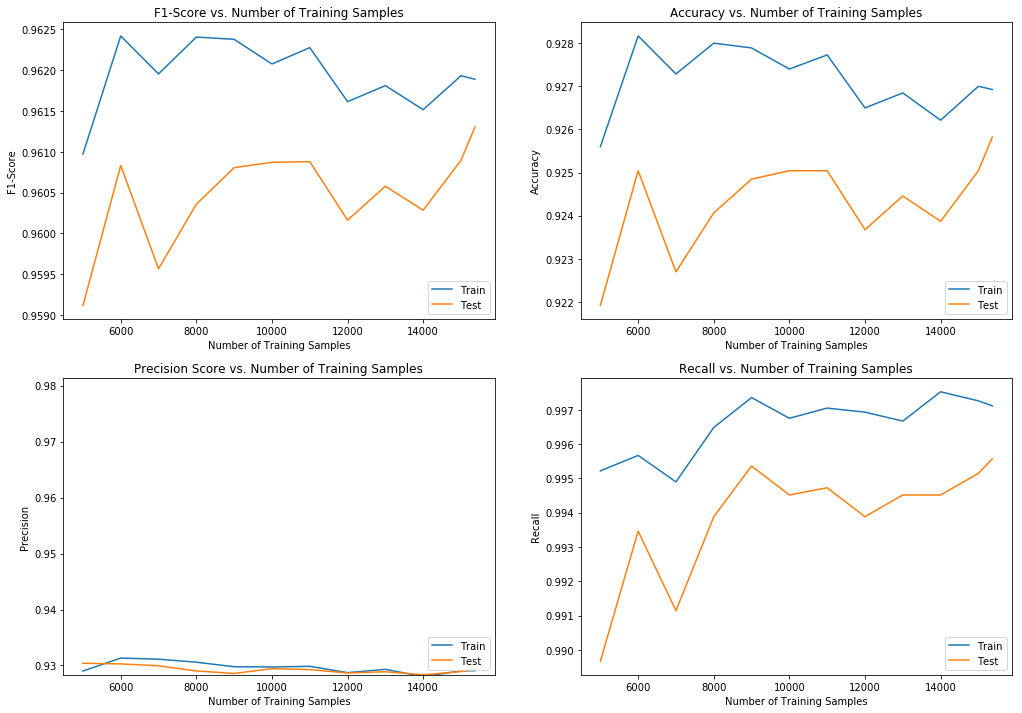

In [45]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(rcf_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

Random Forest
Using body from the dataset

In [47]:
rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)
rcf_body.fit(X_body_tfidf_train, y_body_train)
y_rc_body_pred = rcf_body.predict(X_body_tfidf_test)

In [48]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_rc_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_rc_body_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 65.32%
Accuracy score 92.14%


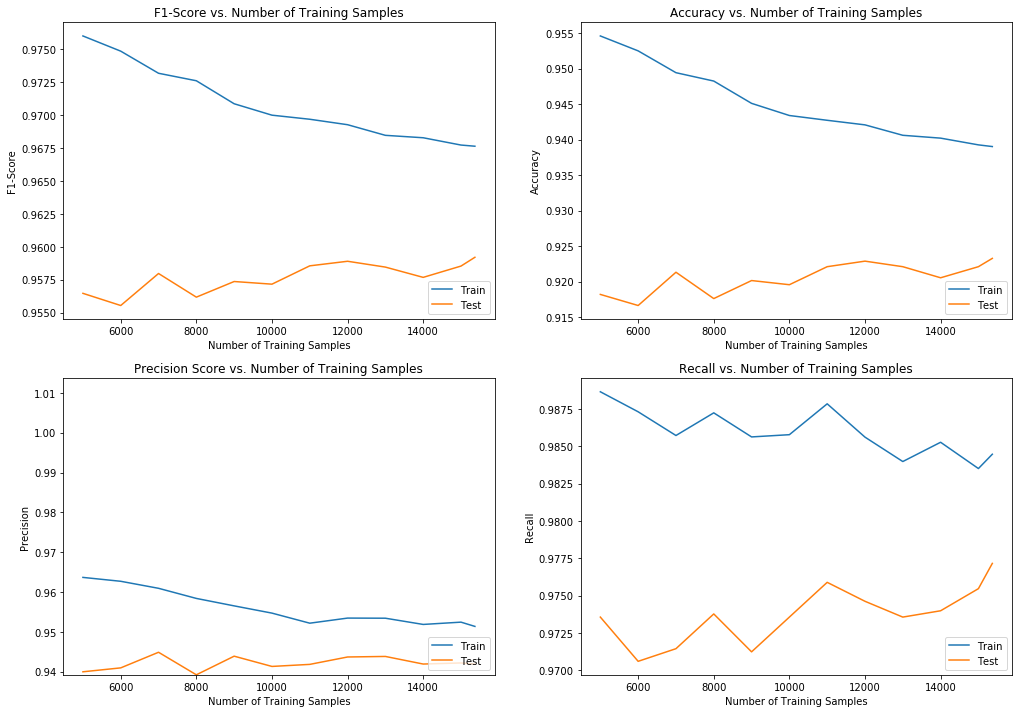

In [49]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(rcf_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

Lightgbm 
Using headlines from the dataset

In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_headline_tfidf_train, y_headline_train)
lgb_eval = lgb.Dataset(X_headline_tfidf_test, y_headline_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_headline_tfidf_test, num_iteration=gbm.best_iteration)
# eval
print(y_pred)
print('The roc of prediction is:', roc_auc_score(y_headline_test, y_pred) )

Start training...
[1]	valid_0's l2: 0.231814	valid_0's auc: 0.699568
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.215395	valid_0's auc: 0.723847
[3]	valid_0's l2: 0.200624	valid_0's auc: 0.726996
[4]	valid_0's l2: 0.187387	valid_0's auc: 0.76024
[5]	valid_0's l2: 0.175387	valid_0's auc: 0.764507
[6]	valid_0's l2: 0.164504	valid_0's auc: 0.771357
[7]	valid_0's l2: 0.154713	valid_0's auc: 0.775765
[8]	valid_0's l2: 0.145898	valid_0's auc: 0.776995
[9]	valid_0's l2: 0.137968	valid_0's auc: 0.77688
[10]	valid_0's l2: 0.130794	valid_0's auc: 0.777264
[11]	valid_0's l2: 0.124324	valid_0's auc: 0.778819
[12]	valid_0's l2: 0.118515	valid_0's auc: 0.779631
[13]	valid_0's l2: 0.113269	valid_0's auc: 0.779211
[14]	valid_0's l2: 0.108509	valid_0's auc: 0.78092
[15]	valid_0's l2: 0.104207	valid_0's auc: 0.780848
[16]	valid_0's l2: 0.100272	valid_0's auc: 0.781702
[17]	valid_0's l2: 0.0967195	valid_0's auc: 0.782156
[18]	valid_0's l2: 0.0935114	valid_0's auc: 0.78

Lightgbm 
Using body from the dataset

In [14]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_body_tfidf_train, y_body_train)
lgb_eval = lgb.Dataset(X_body_tfidf_test, y_body_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_body_tfidf_test, num_iteration=gbm.best_iteration)
# eval
print(y_pred)
print('The roc of prediction is:', roc_auc_score(y_body_test, y_pred) )

Start training...
[1]	valid_0's l2: 0.23121	valid_0's auc: 0.751694
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.214129	valid_0's auc: 0.782365
[3]	valid_0's l2: 0.198771	valid_0's auc: 0.786853
[4]	valid_0's l2: 0.184943	valid_0's auc: 0.805673
[5]	valid_0's l2: 0.172416	valid_0's auc: 0.820959
[6]	valid_0's l2: 0.160968	valid_0's auc: 0.836385
[7]	valid_0's l2: 0.150762	valid_0's auc: 0.836442
[8]	valid_0's l2: 0.141472	valid_0's auc: 0.841682
[9]	valid_0's l2: 0.133122	valid_0's auc: 0.842832
[10]	valid_0's l2: 0.125553	valid_0's auc: 0.843131
[11]	valid_0's l2: 0.118897	valid_0's auc: 0.84206
[12]	valid_0's l2: 0.112814	valid_0's auc: 0.845438
[13]	valid_0's l2: 0.107292	valid_0's auc: 0.845202
[14]	valid_0's l2: 0.102277	valid_0's auc: 0.845733
[15]	valid_0's l2: 0.0978353	valid_0's auc: 0.845312
[16]	valid_0's l2: 0.0937637	valid_0's auc: 0.846575
[17]	valid_0's l2: 0.0901503	valid_0's auc: 0.848458
[18]	valid_0's l2: 0.0868013	valid_0's auc: 0